# Averaging Example
Create small averaging example for paper

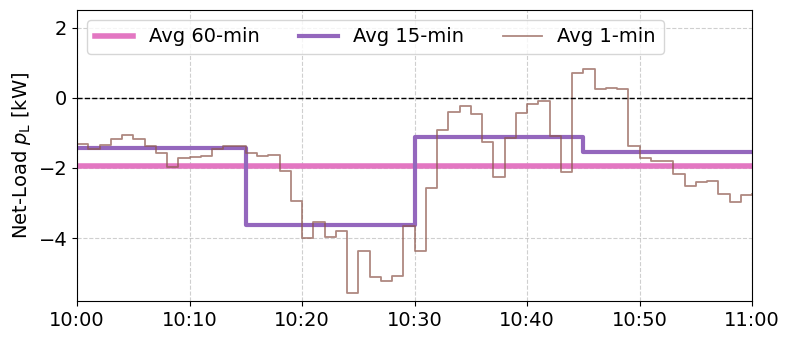

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- sizing presets ----
FS_LABEL = 14
FS_TICK  = 14
FS_LEG   = 14
FS_TITLE = 14

plt.rcParams.update({
    "axes.labelsize": FS_LABEL,
    "xtick.labelsize": FS_TICK,
    "ytick.labelsize": FS_TICK,
    "legend.fontsize": FS_LEG,
    "axes.titlesize": FS_TITLE,

})

# ---------- synthetic data ----------
np.random.seed(42)
periods = 60  # 60 minutes (1 hour) @ 1-minute resolution
time_index = pd.date_range("2025-01-01 12:00", periods=periods, freq="1min")

def noisy_series(avg, std, size):
    noise = np.random.normal(0.0, std, size=size)
    series = avg + noise
    series += (avg - series.mean())  # recenter to exact mean
    return series

# Generation ~ -2 kW (negative => exporting)
gen = noisy_series(avg=-2.0, std=1.0, size=periods)

# Consumption: first half ~ 4 kW, second half ~ 1 kW
cons = np.concatenate([
    noisy_series(avg=4.0, std=1.0, size=periods//2),
    noisy_series(avg=1.0, std=1.0, size=periods - periods//2),
])

df = pd.DataFrame({"Consumption": cons, "Generation": gen}, index=time_index)
df["Prosumption"] = df["Consumption"] + df["Generation"]  # + => import, - => export


# ----------- real-time series (1min) ----------
path_to_data = "/srv/fh6281/GermanBuildingDate/01_data/prosumption_data/1min/prosumption_SFH3_num_pv_modules_26_pv_SOUTH_hp_1.0.csv"
df_real = pd.read_csv(path_to_data, parse_dates=True, usecols=["index", "P_TOT"], index_col=0) # , usecols=["P_TOT"] index_col=0, 
df_real.index = pd.to_datetime(df_real.index)
# drop all values before 2020-08-01
df_real = df_real[df_real.index >= "2020-08-01"]
# divide all values by 1000 to convert W to kW
df_real["P_TOT"] = df_real["P_TOT"] / 1000.0

# Select one hour as example
start = pd.Timestamp("2020-09-04 10:00", tz="UTC")
end = pd.Timestamp("2020-09-04 11:00", tz="UTC")
df_real = df_real[start:end]
time_index = pd.date_range(start, periods=periods, freq="1min")
df_real.rename(columns={"P_TOT": "Prosumption"}, inplace=True)
df = df_real.copy()
# Ensure index is DatetimeIndex for resampling
df.index = pd.to_datetime(df.index)




# ---------- averages at 15min and 60min ----------
avg_1h   = df["Prosumption"].mean()
avg_15mn = df["Prosumption"].resample("15min").mean().reindex(time_index, method="pad")

df_avg = pd.DataFrame(index=time_index)
df_avg["15 min"] = avg_15mn
df_avg["60 min"] = avg_1h

# add last point for step plot
step = df.index[1] - df.index[0]
#df     = pd.concat([df,     pd.DataFrame(df.iloc[[-1]],     index=[df.index[-1]     + step])])
df_avg = pd.concat([df_avg, pd.DataFrame(df_avg.iloc[[-1]], index=[df_avg.index[-1] + step])])

# convert x-axis to HH:MM strings for prettier ticks
df.index     = df.index.strftime("%H:%M")
df_avg.index = df_avg.index.strftime("%H:%M")

# ---------- figure: single panel ----------
plt.figure(figsize=(8, 3.5))
plt.step(df_avg.index, df_avg["60 min"], label="Avg 60-min", where="post", color='C6', linewidth=4)
plt.step(df_avg.index, df_avg["15 min"], label="Avg 15-min", where="post", color='C4', linewidth=3)

plt.step(df.index,     df["Prosumption"], label="Avg 1-min", where="post", color='C5', linewidth=1.3, alpha=0.7)

plt.axhline(0, color="black", linewidth=1.0, linestyle="--")




plt.legend(ncol=3, loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)

# only show every 10th tick
ticks = np.arange(0, len(df.index), 10)
plt.xticks(ticks, df.index[ticks], fontsize=FS_TICK)
plt.xlim(0, len(df.index)-1)
plt.ylim(-5.8,2.5)
#plt.yticks(np.arange(-2, 4, 2), fontsize=FS_TICK)

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
# })
import matplotlib as mpl

ax = plt.gca()
with mpl.rc_context({'mathtext.fontset': 'stix', 'mathtext.default': 'it'}):
    ax.set_ylabel("Net-Load $p_\\mathrm{L}$ [kW]", fontsize=FS_LABEL)
plt.tight_layout()
#plt.savefig("toy-example-real-data-plbad.pdf", bbox_inches="tight")
plt.show()
